In [ ]:
import coremltools as ct
import numpy as np
import pandas as pd
import os
import math
import rawpy
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

train_list_path = "../SID/versions/2/Sony_train_list.txt"
val_list_path = "../SID/versions/2/Sony_val_list.txt"
test_list_path = "../versions/2/Sony_test_list.txt"

# PREPARE DATA

In [ ]:
Lines = []
with open(test_list_path, 'r') as file:
    for line in file:
        Lines.append(line.strip())
print(Lines[0])

In [3]:
train = pd.read_csv(train_list_path, sep=' ', header=None)
val = pd.read_csv(val_list_path, sep=' ', header=None)
test = pd.read_csv(test_list_path, sep=' ', header=None)
Columns = ['Short', 'Long', 'ISO', 'Focal Length']
train.columns = Columns
val.columns = Columns
test.columns = Columns

## Helper Functions

In [ ]:
"""
This function takes in one row, and returns the RGB array corresponding to the bayer image using rawpy.
"""
def input_to_image(row):
    root_path = "../SID/versions/2"
    short_path = root_path + row['Short'][1:]

    with rawpy.imread(short_path) as raw:
        bayer = raw.raw_image_visible
        black_level = raw.black_level_per_channel
        rgb_1 = raw.postprocess()
        # rgb_2 = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
    return rgb_1

In [ ]:
"""
The raw Bayer image is a 2D array of pixels. This function splits them into 4 channels : Red, Green1, Green2, and Blue.
The black level is removed, as per the paper.
"""

def load_pair_from_row(row, root_path="../SID/versions/2"):
    # Load short image
    short_path = root_path + row['Short'][1:]
    long_path = root_path + row['Long'][1:]
    ratio = float(long_path[71:-5]) / float(short_path[72:-5])
    with rawpy.imread(short_path) as raw:
        bayer = torch.tensor(raw.raw_image_visible.astype('float32'), dtype=torch.float32)
        black = raw.black_level_per_channel
        red = bayer[0::2, 0::2] - black[0]
        green1 = bayer[0::2, 1::2] - black[1]
        green2 = bayer[1::2, 0::2] - black[2]
        blue = bayer[1::2, 1::2] - black[3]
        X = torch.clamp(torch.stack([red, green1, blue, green2]), 0) * ratio

    # Load long image
    with rawpy.imread(long_path) as raw:
        rgb = torch.tensor(raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16), dtype=torch.float32)
        img = rgb.permute(2, 0, 1)
        Y = img / 65535.0

    return X, Y

In [ ]:
"""
The RAW bayer images are large (2848, 4256), which after splitting into 4 channels by the function load_pair_from_row() is
of shape (4, 1424, 2128) which is too large to be handled by even moderate GPUs, and backprop will stall.

Hence, (4, 256, 256) patches are taken from the (4, 1424, 2128) tensors and training is done on these patches.
For a (4, 1424, 2128) tensor, there are 54 patches each of shape (4, 256, 256) including the padded patch.
Similarly, the label image is also a bayer image of shape (2848, 4256) which in RGB is -> (3, 2848, 4256), and is patched
into patches of shape (3, 512, 512).

So, for each row, we have:
    Input Image     : (2848, 4256)
    Output Image    : (2848, 4256)

The input bayer image is split and patched.
The output bayer image is converted to RGB, and then patched.

For each 3D image, there are 54 patches. Which can be considered as a batch of images.
So finally, 

    Batched input to model for 1 row    : X -> (54, 4, 256, 256)
    Batched output from model for 1 row : Y -> (54, 3, 512, 512)
"""
def extract_patches_pixelshuffle(row, input_patch=256, label_patch=512, stride=512):
    X, Y = load_pair_from_row(row)

    _, H, W = Y.shape

    X_patches = []
    Y_patches = []

    
    num_rows = math.ceil((H - label_patch) / stride) + 1
    num_cols = math.ceil((W - label_patch) / stride) + 1


    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            top = row_idx * stride
            left = col_idx * stride

            
            Y_patch = Y[:, top:top+label_patch, left:left+label_patch]
            pad_H = label_patch - Y_patch.shape[1]
            pad_W = label_patch - Y_patch.shape[2]
            if pad_H > 0 or pad_W > 0:
                Y_patch = F.pad(Y_patch, (0, pad_W, 0, pad_H))  # pad (left, right, top, bottom)

            
            top_lr = top // 2
            left_lr = left // 2
            X_patch = X[:, top_lr:top_lr+input_patch, left_lr:left_lr+input_patch]
            pad_H_lr = input_patch - X_patch.shape[1]
            pad_W_lr = input_patch - X_patch.shape[2]
            if pad_H_lr > 0 or pad_W_lr > 0:
                X_patch = F.pad(X_patch, (0, pad_W_lr, 0, pad_H_lr))

            X_patches.append(X_patch)
            Y_patches.append(Y_patch)

    X = torch.stack(X_patches)
    Y = torch.stack(Y_patches)
    return X, Y
"""
Now, since the output of the model is 54 3D images, each being a patch, we need to stitch them to form the complete image.
The same is achieved by this stitch_patches() function.

Takes a tensor 'patches' as input : (54, 3, 512, 512)
Returns an RGB image of shape (3, 2848, 4256)
"""
def stitch_patches(patches, n_rows=6, n_cols=9, patch_size=512, out_channels=3):
    H_full = n_rows * patch_size
    W_full = n_cols * patch_size

    stitched = torch.zeros((out_channels, H_full, W_full))

    idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            top = i * patch_size
            left = j * patch_size
            stitched[:, top:top+patch_size, left:left+patch_size] = patches[idx]
            idx += 1

    return stitched[:, :2848, :4256]

In [ ]:
"""
It is mentioned in the paper that each patch is randomly flipped during training, along with its label patch.
The same is achieved by this function random_flip_batch()
"""

def random_flip_batch(X, Y):
    
    B, C, H, W = X.shape
    
    flip_h = torch.rand(B) < 0.5
    flip_v = torch.rand(B) < 0.5

    # Apply flips as given in paper
    for i in range(B):
        if flip_h[i]:
            X[i] = torch.flip(X[i], dims=[2])
            Y[i] = torch.flip(Y[i], dims=[2])
        if flip_v[i]:
            X[i] = torch.flip(X[i], dims=[1])
            Y[i] = torch.flip(Y[i], dims=[1])
    
    return X, Y


"""
Each input image after patching is of shape (54, 4, 256, 256), and corresponding label after patching is of shape (54, 3, 512, 512)
This can be considered as a batch of 54 data points. Multiple such can be forwarded at once depending on GPU availabiity.

This function batch_extract_patches_pixelshuffle() achieves the same, and randomly flips the images for training.
"""
def batch_extract_patches_pixelshuffle(rows, test = False):
    X_all = []
    Y_all = []

    index = 0
    for index in range(len(rows)):
        row = train.iloc[index]
    # for index, row in rows.iterrows():
        X, Y = extract_patches_pixelshuffle(row)
        if test is False:
            X, Y = random_flip_batch(X, Y)
        X_all.append(X)  # X: (num_patches_row, C, H, W)
        Y_all.append(Y)

    X_all = torch.cat(X_all, dim=0)
    Y_all = torch.cat(Y_all, dim=0)
    return X_all, Y_all

# UNet Model

The UNet Model is as described in the paper.

In [4]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()

        self.Block_1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.Block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.Block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.Block_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.Block_5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )

        self.Upsample_6 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.Block_6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )

        self.Upsample_7 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.Block_7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )

        self.Upsample_8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.Block_8 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )

        self.Upsample_9 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.Block_9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, dilation=1),
            nn.GELU(),
        )

        self.Block_10 = nn.Conv2d(in_channels=32, out_channels=12, kernel_size=1, padding=0, dilation=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)

    def forward(self, x):
        conv_1 = self.Block_1(x)        # x : (B, 4, 1424, 2128) -> conv_1 : (B, 32, 1424, 2128)
        # print(f"conv_1 : {conv_1.shape}")
        down_1 = self.pool_1(conv_1)    # conv_1 : (B, 32, 1424, 2128) -> down_1 : (B, 32, 712, 1064)
        # print(f"down_1 : {down_1.shape}")

        conv_2 = self.Block_2(down_1)
        # print(f"conv_2 : {conv_2.shape}")
        down_2 = self.pool_2(conv_2)
        # print(f"down_2 : {down_2.shape}")

        conv_3 = self.Block_3(down_2)
        # print(f"conv_3 : {conv_3.shape}")
        down_3 = self.pool_3(conv_3)
        # print(f"down_3 : {down_3.shape}")

        conv_4 = self.Block_4(down_3)
        # print(f"conv_4 : {conv_4.shape}")
        down_4 = self.pool_4(conv_4)
        # print(f"down_4 : {down_4.shape}")

        conv_5 = self.Block_5(down_4)
        # print(f"conv_5 : {conv_5.shape}")

        upsampled = self.Upsample_6(conv_5)
        up6 = torch.cat((upsampled, conv_4), dim=1)
        # print(f"up6 : {up6.shape}")
        conv_6 = self.Block_6(up6)
        # print(f"conv_6 : {conv_6.shape}")

        upsampled = self.Upsample_7(conv_6)
        up7 = torch.cat((upsampled, conv_3), dim=1)
        # print(f"up7 : {up7.shape}")
        conv_7 = self.Block_7(up7)
        # print(f"conv_7 : {conv_7.shape}")

        upsampled = self.Upsample_8(conv_7)
        up8 = torch.cat((upsampled, conv_2), dim=1)
        # print(f"up8 : {up8.shape}")
        conv_8 = self.Block_8(up8)
        # print(f"conv_8 : {conv_8.shape}")

        upsampled = self.Upsample_9(conv_8)
        up9 = torch.cat((upsampled, conv_1), dim=1)
        # print(f"up9 : {up9.shape}")
        conv_9 = self.Block_9(up9)
        # print(f"conv_9 : {conv_9.shape}")

        conv_10 = self.Block_10(conv_9)
        # print(f"conv_10 : {conv_10.shape}")
        out = self.pixel_shuffle(conv_10)
        # print(f"out : {out.shape}")

        return out

# Training Loop

In [10]:
from collections import OrderedDict

Currently using the integrated GPU on a MAC.

If nvidia gpus are available, change :
$$\mathrm{device} = ``mps" \rightarrow \mathrm{device} = ``CUDA"$$ 

In [ ]:
device = "mps"
model = UNET()
model_path = "../SID/model_for_mps.pt"
model.load_state_dict(torch.load(model_path))

/var/folders/8q/900d6xjx4zjbpsy0kccygxbr0000gn/T/ipykernel_13880/2501287851.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [12]:
optimiser = optim.AdamW(params=model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

In [ ]:
"""
row_batch_size denotes the number of rows to pick in one go.
row_batch_size = 10. Means 10 rows are picked -> 10 x (54, 4, 256, 256) inputs and 10 x (54, 3, 512, 512) outputs stacked:
So we have (540, 4, 256, 256) inputs and (540, 3, 512, 512) outputs. These images are tensors stored in RAM.
Hence picking only few (10) images in RAM at once and creating a dataloader for training.
"""

row_batch_size = 10

Losses = []
for epoch in range(2):
    for i in tqdm(range(0, len(train), row_batch_size)):
        row_batch = train[i : i + row_batch_size]
        data, label = batch_extract_patches_pixelshuffle(row_batch)
        tensor_dataset = TensorDataset(data, label)
        data_loader = DataLoader(tensor_dataset, batch_size=16*3, shuffle=True, num_workers=3)
        optimiser.zero_grad()
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)

            outputs = model(X)
            loss = criterion(outputs, Y)
            loss.backward()
            Losses.append(loss.item())
        optimiser.step()
    # output_path = "../SID/Models/model_weights.pt"
    # torch.save(model.state_dict(), output_path)


100%|██████████| 187/187 [32:15<00:00, 10.35s/it]


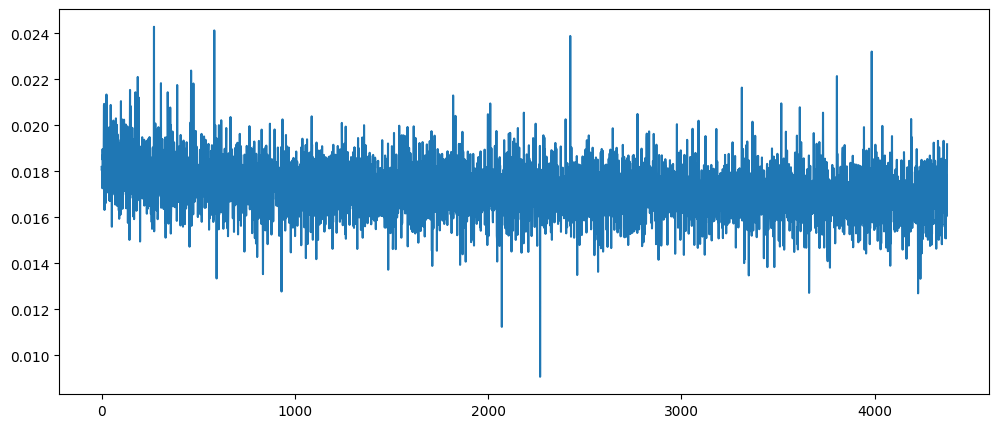

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(Losses[100:])
plt.show()

# Testing

In [ ]:
device = "mps"
model = UNET()
model_path = "../SID/model_for_mps.pt"
model.load_state_dict(torch.load(model_path))
model = model.to(device)

/var/folders/8q/900d6xjx4zjbpsy0kccygxbr0000gn/T/ipykernel_13880/2952283130.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

To test on any image, take any row from test.csv and perform splitting and patching as done during training.

For ease, I have taken one row from test.csv and saved as tensor to be loaded without downloading the whole dataset.

In [ ]:
data = torch.load("../SID/Test Images/Tensor short image/bayer_4_channels_point_04s.pt", weights_only=False)
label = torch.load("../SID/Test Images/Tensor long image/bayer_4_channels_10s.pt", weights_only=False)


### Perform forward pass for test image

In [8]:
with torch.no_grad():
    predicted = model(data.to(device)).cpu()

Output is a tensor (54, 3, 512, 512) for one image input.

Stitch it back to (3, 2848, 4256) : (Channels, Height, Width), and rearrange the dimensions to (2848, 4256, 3) : (Height, Width, Channels)

In [9]:
recovered = np.clip(stitch_patches(predicted).numpy().transpose(1, 2, 0), 0, 1)
ground_truth = np.clip(stitch_patches(label).numpy().transpose(1, 2, 0), 0, 1)

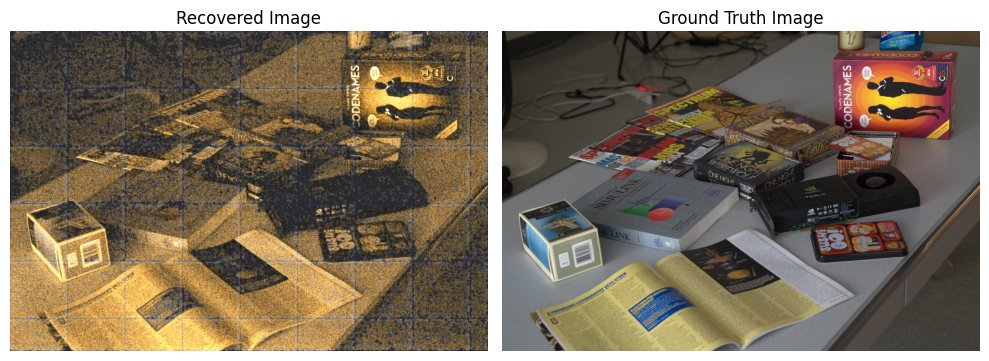

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(recovered)
axes[0].set_title("Recovered Image")
axes[0].axis('off')

axes[1].imshow(ground_truth)
axes[1].set_title("Ground Truth Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### To convert model to Apple ML-Model

In [ ]:
model.eval()
example_input = torch.randn((54, 4, 256, 256), dtype=torch.float32, device=device)
traced_model = torch.jit.trace(model, example_input)
mlmodel = ct.convert(traced_model, inputs=[ct.TensorType(name="input", shape=example_input.shape)])
mlmodel.save("../SID/Mac Model/SonyModel.mlpackage")